In [6]:
import os
import numpy as np
import pandas as pd
from csv import writer
from heapq import merge
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from pyspark.sql.types import IntegerType
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

22/10/07 23:40:43 WARN Utils: Your hostname, Hyunjin-Win11 resolves to a loopback address: 127.0.1.1; using 172.28.60.218 instead (on interface eth0)
22/10/07 23:40:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 23:40:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- sa2_name_2016: string (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- erp_2013: integer (nullable = true)
 |-- erp_2014: integer (nullable = true)
 |-- erp_2015: integer (nullable = true)
 |-- erp_2016: integer (nullable = true)
 |-- erp_2017: integer (nullable = true)
 |-- erp_2018: integer (nullable = true)
 |-- erp_2019: integer (nullable = true)
 |-- erp_2020: integer (nullable = true)
 |-- erp_2021: integer (nullable = true)



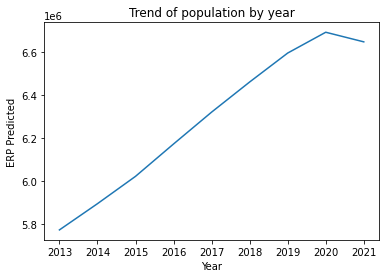

In [7]:
# Extract ERP for each year (Estimated Residential Population)
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

erp_predicted = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/erp_vic.csv", header=True)

erp_predicted = erp_predicted.withColumn("erp_2013",erp_predicted["erp_2013"].cast(IntegerType()))\
                                .withColumn("erp_2014",erp_predicted["erp_2014"].cast(IntegerType()))\
                                .withColumn("erp_2015",erp_predicted["erp_2015"].cast(IntegerType()))\
                                .withColumn("erp_2016",erp_predicted["erp_2016"].cast(IntegerType()))\
                                .withColumn("erp_2017",erp_predicted["erp_2017"].cast(IntegerType()))\
                                .withColumn("erp_2018",erp_predicted["erp_2018"].cast(IntegerType()))\
                                .withColumn("erp_2019",erp_predicted["erp_2019"].cast(IntegerType()))\
                                .withColumn("erp_2020",erp_predicted["erp_2020"].cast(IntegerType()))\
                                .withColumn("erp_2021",erp_predicted["erp_2021"].cast(IntegerType()))

erp_predicted.printSchema()

# Graph the erp trend line to decide how to predict erp from 2022 - 2027
erp_agg = erp_predicted.groupby().sum().toPandas()

year = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

y_axis = erp_agg.iloc[0]

plt.plot(year,y_axis)
plt.title('Trend of population by year')
plt.xlabel('Year')
plt.ylabel('ERP Predicted')
plt.show()

The ERP (estiamted resident population) in Victoria state increases as year progresses with a linear relatonship. it shows a decline between 2020 to 2021, but according to the data from Australian government (`https://population.gov.au/data-and-forecasts/key-data-releases/national-state-and-territory-population-december-2021`) they stated that the decline happened due to the impact of COVID. Since in this project, we assume that COVID will not stay any longer or will have a huge impact as it did between 2019 to 2021 as most of the population is vaccinated by now. Therefore, from this, we got an idea of using a linear regression for our population prediction for 2023-2027.

In [8]:
# Define external predictors
external_preds = ['sa2_2021', 'min_distance_to_cbd','min_distance_to_park', 'min_distance_to_prim', 'min_distance_to_second'\
    , 'min_distance_to_train', 'min_distance_to_hosp', 'min_distance_to_poli', 'min_distance_to_shop', 'gdp', 'saving_rate', 'income_per_person',\
        'crime_cases', 'population_density']

# Define internal predictors
internal_preds = ['residence_type', 'nbed', 'nbath', 'ncar']

# OLS regression function for Data analysis
def ols_regression(merged_df):
    # OLS Regression
    # External ----------------------------------------------------------------------------------------------------
    external_model = ols(formula = 'weekly_rent ~ C(sa2_2021) + min_distance_to_cbd + \
        min_distance_to_park + min_distance_to_prim + min_distance_to_second + min_distance_to_train +\
        min_distance_to_hosp + min_distance_to_poli + min_distance_to_shop + gdp + saving_rate + income_per_person +\
        crime_cases + population_density', data = merged_df).fit()

    # Summary of external factors
    ex_summary = external_model.summary()

    print("Summary of external factors: ")
    print(ex_summary)

    # Anova table of external factors
    ex_anova_table = sm.stats.anova_lm(external_model, typ=2)

    print("Anova table of external factors: ")
    print(ex_anova_table)

    # Extract p-values for the predictors
    ex_pvals = external_model.pvalues[:]

    # Internal ----------------------------------------------------------------------------------------------------
    internal_model = ols(formula = 'weekly_rent ~ C(residence_type) + nbed + nbath + ncar', data = merged_df).fit()

    # Summary of internal factors
    in_summary = internal_model.summary()

    print("Summary of internal factors: ")
    print(in_summary)

    # Anova table of internal factors
    in_anova_table = sm.stats.anova_lm(internal_model, typ=2)

    print("Anova table of internal factors: ")
    print(in_anova_table)

    # Extract p-values for the predictors
    in_pvals = internal_model.pvalues[:]

    return ex_pvals, in_pvals

# csv file function
def put_signigicants_csv(external_preds, ex_pvalues, internal_preds, in_pvalues, new_csv):
    print(ex_pvalues, in_pvalues)
    sign_ex_predictors = [external_preds[(pre-1)]  for pre in range(1, len(ex_pvalues)) if ex_pvalues[pre] < 0.05]

    sign_in_predictors = [internal_preds[(pre-1)] for pre in range(1, len(in_pvalues)) if in_pvalues[pre] < 0.05]
    
    external_df = pd.DataFrame({'Significant External predictors': sign_ex_predictors})
    internal_df = pd.DataFrame({'Significant Internal predictors': sign_in_predictors})
    new = pd.concat([external_df, internal_df], axis=1) 

    print(new_csv)
    new.to_csv(new_csv)

In [9]:
# Make a new folder for significant variable csv files
# Directory
directory = "significant"
  
# Parent Directory path
parent_dir = "../data/curated/"

# Path
path = os.path.join(parent_dir, directory)

# Create the directory
os.mkdir(path)

FileExistsError: [Errno 17] File exists: '../data/curated/significant'

      year   sa2_2021  residence_type  nbed  nbath  ncar  min_distance_to_cbd  \
0     2013  204011057               1     2      1     0                  227   
1     2013  205051101               1     2      1     0                  223   
2     2013  204011057               1     2      1     0                  243   
3     2013  202011022               1     4      2     0                  140   
4     2013  208041195               0     1      1     0                   13   
...    ...        ...             ...   ...    ...   ...                  ...   
8567  2013  212051568               1     2      1     1                   25   
8568  2013  205051103               1     3      2     2                  213   
8569  2013  213051368               1     3      2     2                   45   
8570  2013  205031087               0     2      1     1                  150   
8571  2013  209031212               0     1      1     0                   41   

      min_distance_to_park 

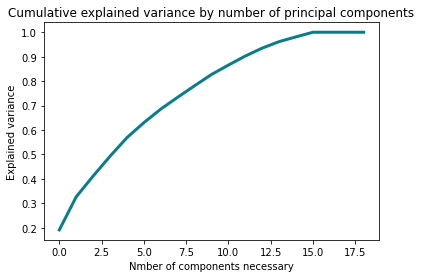

In [13]:
# Testing: Looking into 2013 data only with PCA 
# Scrutinize the data with PCA: Test the attribute relevance
merged_df = spark.read.csv("../data/curated/merged_dataset/2013_merged_data.csv", header=True)

for c in merged_df.columns:
    if (c not in  ['address', 'residence_type']):
        merged_df = merged_df.withColumn(c,merged_df[c].cast(IntegerType())) 

merged_df = merged_df.toPandas()

merged_df['residence_type'] = merged_df['residence_type'].astype('category')
merged_df['residence_type'] = merged_df['residence_type'].cat.codes

# For the missing values of distances between a rental property and each feature of interest, 
# fill them up with a huge value because they are missing as rental properites are far away 
# where API OPen Route cannot measure distances.
merged_df.iloc[:, 13:21] = merged_df.iloc[:, 13:21].replace(np.nan, 99999)

merged_df = merged_df.dropna()

X = merged_df.drop(['address', 'weekly_rent', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1)
y = merged_df['weekly_rent']

print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components')
plt.xlabel("Nmber of components necessary")
plt.ylabel("Explained variance")
plt.show()

By looking at the graph generated by applying PCA on the data 2013, the explained variance value is already reached at its maximum value 100% with only the first 15 features. This means the last 4 features which are saving rate, income_per_person, population_density, and crime_cases are not significant predictors. Since our team predicted that either population density or income per person by SA2 regions will be significant variavles, we decided to proceed other data analysis methods to be sure. 

In [14]:
# Scrutinize the data with PCA: Test the attribute relevance for only 2013 (For testing)
merged_df.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

ex_pvalues, in_pvalues = ols_regression(merged_df)

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     11.59
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:44:20   Log-Likelihood:                -52688.
No. Observations:                8566   AIC:                         1.063e+05
Df Residuals:                    8091   BIC:                         1.097e+05
Df Model:                         474                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 465, but rank is 463
  warnings.warn('covariance of constraints does not have full '


Anova table of external factors: 
                              sum_sq      df          F         PR(>F)
C(sa2_2021)             3.230999e+07   465.0   5.094051  6.282397e-211
min_distance_to_cbd     3.170961e+04     1.0   2.324718   1.273724e-01
min_distance_to_park    4.041633e+04     1.0   2.963032   8.522627e-02
min_distance_to_prim    4.837056e+05     1.0  35.461781   2.709644e-09
min_distance_to_second  1.986056e+02     1.0   0.014560   9.039585e-01
min_distance_to_train   1.167731e+04     1.0   0.856095   3.548613e-01
min_distance_to_hosp    7.752266e+03     1.0   0.568340   4.509413e-01
min_distance_to_poli    5.196136e+05     1.0  38.094297   7.065218e-10
min_distance_to_shop    2.916326e+04     1.0   2.138038   1.437244e-01
gdp                     5.371406e+02     1.0   0.039379   8.427042e-01
saving_rate             3.844264e+04     1.0   2.818335   9.323161e-02
income_per_person       1.492373e+05     1.0  10.940994   9.447008e-04
crime_cases             1.154079e+04     1.

We decided the data into internal and external factors to predict weekly rental prices of rental properties because we wanted to scrutinize the data with more depth. </br> </br>
### Internal factors are:</br>
1. The residence type of a rental property </br>
2. The number of bedrooms of a rental property </br>
3. The number of bathrooms of a rental property</br>
4. The number of car parking spaces of a rental property</br>
</br>

### External factors are: </br>
1. SA2_2021 </br>
2. Minimum distance from a rental property to cbd  </br>
3. Minimum distance from a rental property to a closest park / primary&secondary schools / train station / hospital / police office / shopping mall </br> 
4. Yearly GDP of each SA2 region  </br>
5. Yearly Saving rate of each SA2 region </br>
6. Yearly Income per person by each SA2 region</br>
7. Yearly Crime cases by each SA2 region</br>
8. Yearly Population density by each SA2 region</br>
</br>

**Please note that the following results mentioned in this pargraph is only about 2013** for testing if using anova table and summary table of ols regression can perform data analysis; which features are significant to predict weekly rental price. 
</br>



In [98]:
# Implement for every file to see annual trend
parent_dir = "../data/curated/merged_dataset"

for filename in os.listdir(parent_dir):
    print(filename, "----------------------------------------------------------------------------------------------------------------")
    merged_df_yr = spark.read.csv(parent_dir + "/" + filename, header=True)
    for c in merged_df_yr.columns:
        if (c not in  ['address', 'residence_type']):
            merged_df_yr = merged_df_yr.withColumn(c,merged_df_yr[c].cast(IntegerType())) 

    merged_df_yr = merged_df_yr.toPandas()

    merged_df_yr['residence_type'] = merged_df_yr['residence_type'].astype('category')
    merged_df_yr['residence_type'] = merged_df_yr['residence_type'].cat.codes

    merged_df_yr.iloc[:, 13:21] = merged_df_yr.iloc[:, 13:21].replace(np.nan, 99999)

    merged_df_yr = merged_df_yr.dropna()

    merged_df_yr.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

    # Implement ols regression to analyze the data
    ex_pvalues, in_pvalues = ols_regression(merged_df_yr)
    
    new_csv_name = "../data/curated/significant/" + filename

    put_signigicants_csv(external_preds, ex_pvalues, internal_preds, in_pvalues, new_csv_name)

2013_merged_data.csv ----------------------------------------------------------------------------------------------------------------


Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     208.8
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:03   Log-Likelihood:                -53807.
No. Observations:                8566   AIC:                         1.076e+05
Df Residuals:                    8553   BIC:                         1.077e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     166.5
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:09   Log-Likelihood:            -1.3250e+05
No. Observations:               19369   AIC:                         2.650e+05
Df Residuals:                   19356   BIC:                         2.651e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     453.3
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:21   Log-Likelihood:            -3.6624e+05
No. Observations:               53696   AIC:                         7.325e+05
Df Residuals:                   53683   BIC:                         7.326e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     431.7
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:26   Log-Likelihood:                -90293.
No. Observations:               14206   AIC:                         1.806e+05
Df Residuals:                   14193   BIC:                         1.807e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     340.1
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:46   Log-Likelihood:                -83086.
No. Observations:               12973   AIC:                         1.662e+05
Df Residuals:                   12960   BIC:                         1.663e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     342.2
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:50   Log-Likelihood:                -63523.
No. Observations:               10245   AIC:                         1.271e+05
Df Residuals:                   10232   BIC:                         1.272e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     451.3
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:54   Log-Likelihood:            -1.0270e+05
No. Observations:               16029   AIC:                         2.054e+05
Df Residuals:                   16016   BIC:                         2.055e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

22/09/29 19:22:46 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 131767 ms exceeds timeout 120000 ms
22/09/29 19:22:47 WARN SparkContext: Killing executors is not supported by current scheduler.
